# HomeWork Project Juypter Book

# Matthew Anderson | 801203905 & Harshil LastName | 801#####

# Github https://github.com/Mand187/IOT-ML-Tiny-ML-

NOTE FOR GRADER : THIS NOTEBOOK REQUIRES MULTIPLE FILES AS OUTLINE IN THE IMPORT LIST, OTHERWISE THIS WILL NOT WORK


Model:
Recognize 2+ keywords, 1 custom word (not from Google 30)
Deploy on Arduino Nano 33 BLE Sense
Must support live/streaming detection

Data:

Record and augment your own .wav files
Collaboration allowed for data collection (not code)

Deliverables:

PDF report (design, training, results, etc.)
Demo video
GitHub repo with required structure
Live demo and final presentation

Grading:
Specs (30%), Performance (20%), Exploration (10%), Report (20%), Presentation (10%), Demo (10%)

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# === Setup ===
import os
import time
from datetime import datetime
import tensorflow as tf
import numpy as np

# Import custom modules
import config
import utils.data_utils as data_utils
from model.model import *
from model.saveModel import *
from model.train_eval import *
import visualization.visualization as visualization
from visualization.visualization import *
import utils.audio_utils as audio_utils

In [2]:
# === Configuration ===
config.EPOCHS = 10
config.BATCH_SIZE = 32
config.COMMANDS = ['stop', 'internet']   # choose your two keywords
config.DATASET = 'mini-speech'       # mini-speech, or full-speech-files
config.LIMIT_POSITIVE_SAMPLES = True
config.MAX_WAVS_0 = 500  # max number of positive samples per command
config.MAX_WAVS_1 = 500  # max number of negative samples per command
config.LIMIT_OTHER_SAMPLES = False


# Print current configuration
config.print_configuration()

# === Training Pipeline ===

# Start timer
t0 = time.time()

# Get file lists
train_files, val_files, test_files = data_utils.get_files_distribution()
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

FFT window length = 1024
Learning rate: 0.001
Commands: ['stop', 'internet']
Label list: ['_silence', '_unknown', 'stop', 'internet']
Number of total examples: 11001
Using mini-speech
Training set size 8800
Validation set size 1100
Test set size 1101
We have 8800/1100/1101 training/validation/test files


In [ ]:
# === Prepare Datasets ===
train_ds, val_ds, test_ds, input_shape = data_utils.prepare_datasets(
    train_files, val_files, test_files)

print(f"Input shape: {input_shape}")

Limited samples: stop=500, internet=500
Preparing datasets from 6608/1100/1101 files
Processing 6608 files
Added 1322 silent wavs and noisy samples
About to create spectrograms from 15930 waves
 15750 wavs processedProcessing 1100 files
Added 221 silent wavs and noisy samples
About to create spectrograms from 1321 waves
 1250 wavs processedProcessing 1101 files
Added 221 silent wavs and noisy samples
About to create spectrograms from 1322 waves
 1250 wavs processedInput shape: (20, 32, 1)


In [4]:
# === Build Model ===
#config.LEARNING_RATE = 0.00005
config.LEARNING_RATE = 0.000055
model = projectModel(input_shape, learning_rate=config.LEARNING_RATE, l2=1e-4) 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 18, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 18, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 18, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 9, 15, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 13, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 13, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 13, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 4, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 2, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 1, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 227,076 (887.02 KB)

 Trainable params: 225,860 (882.27 KB)

 Non-trainable params: 1,216 (4.75 KB)

In [5]:
# === Train Model ===
history = train_model(model, train_ds, val_ds, epochs=20)

Epoch 1/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4917 - loss: 1.2912 - val_accuracy: 0.6457 - val_loss: 0.8321
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7214 - loss: 0.7930 - val_accuracy: 0.7820 - val_loss: 0.5694
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7835 - loss: 0.6409 - val_accuracy: 0.8547 - val_loss: 0.4559
Epoch 4/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8275 - loss: 0.5432 - val_accuracy: 0.8796 - val_loss: 0.4249
Epoch 5/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8521 - loss: 0.4778 - val_accuracy: 0.9039 - val_loss: 0.3496
Epoch 6/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8677 - loss: 0.4333 - val_accuracy: 0.9152 - val_loss: 0.3226
Epoch 7/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8867 - loss: 0.3820 - val_accuracy: 0.9160 - val_loss: 0.3011
Epoch 8/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9017 - loss: 0.3502 - val_accuracy: 0.

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Manual test set accuracy: 95.5%
42/42 - 0s - 2ms/step - accuracy: 0.9546 - loss: 0.1968
True/False positive rate for '_silence ' = 0.910 / 0.002
True/False positive rate for '_unknown ' = 0.966 / 0.021
True/False positive rate for 'stop     ' = 0.895 / 0.032
True/False positive rate for 'internet ' = 0.983 / 0.006


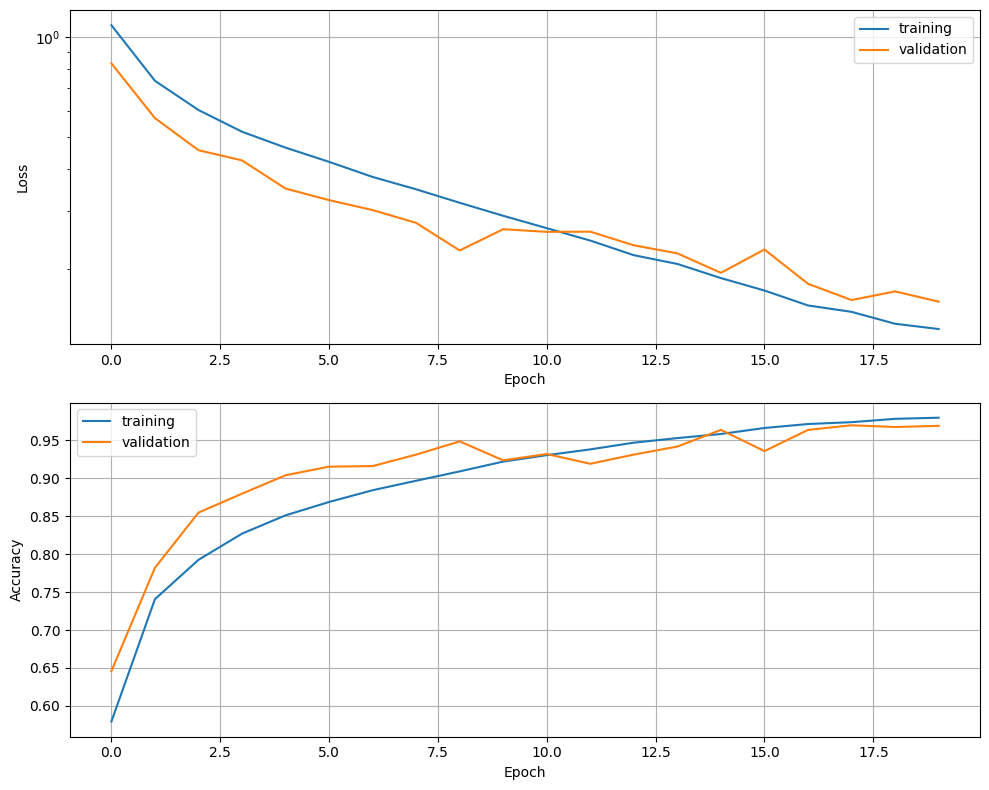

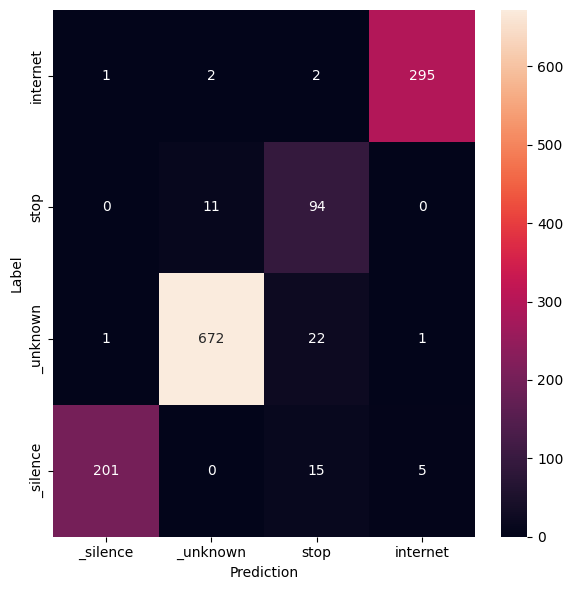

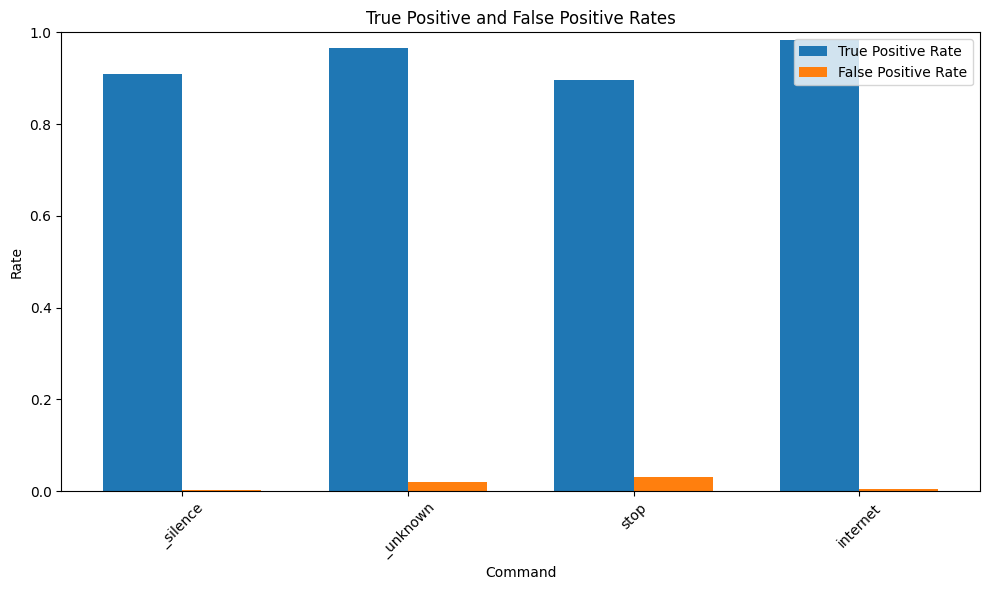

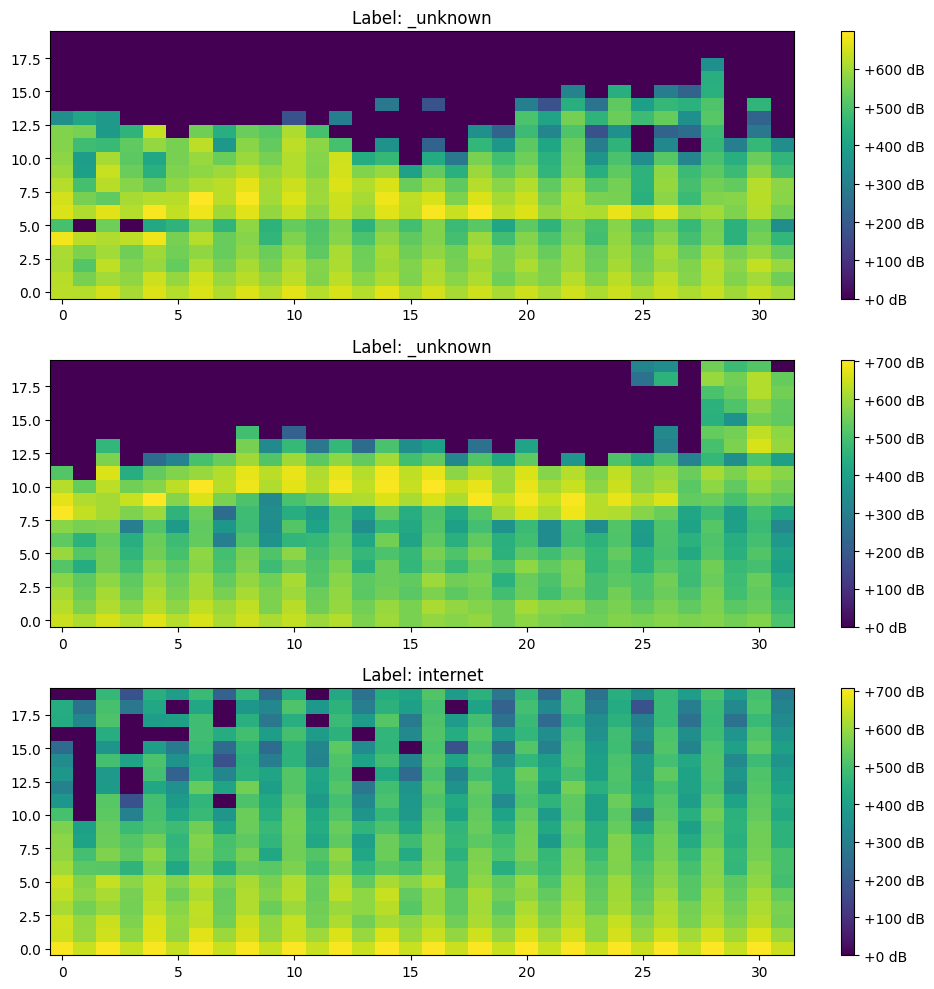

Wrote description to output/text\ProjectModel_STOP_INTERNET.txt


'output/text\\ProjectModel_STOP_INTERNET.txt'

In [8]:
# === Evaluate Model ===
test_loss, test_acc, confusion_mtx, tpr, fpr = evaluate_model(model, test_ds)

# Save example spectrogram shape for info
for spectrogram, _ in train_ds.take(1):
    spectrogram_shape = spectrogram[0].shape

# === Visualizations ===

visualization.plot_training_history(history)
visualization.visualize_model_performance(confusion_mtx, tpr, fpr)
visualization.plot_example_spectrograms(train_ds)


model_file_name = f"ProjectModel_STOP_INTERNET"
save_model_info(model_file_name, test_acc, tpr, fpr, spectrogram_shape)

In [9]:
model_filepath = save_model(model, model_file_name)
print(f"Model saved to {model_filepath}")

convert_and_save_tflite_model(model_filepath, val_ds, model_file_name, num_calibration_steps=10)

Saving model to output/model\ProjectModel_STOP_INTERNET.h5
Model saved to output/model\ProjectModel_STOP_INTERNET.h5
INFO:tensorflow:Assets written to: C:\Users\Matt\AppData\Local\Temp\tmpzj11o4_w\assets


INFO:tensorflow:Assets written to: C:\Users\Matt\AppData\Local\Temp\tmpzj11o4_w\assets


Saved artifact at 'C:\Users\Matt\AppData\Local\Temp\tmpzj11o4_w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20, 32, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2137183777808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2137183777040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2137180002768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2137180001232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2137180001808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2137180002192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2137180000656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2137180003536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2137180002960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2137180004112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  213718000

C:\Users\Matt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Wrote 246832 / 246832 bytes to tflite file at output/model\ProjectModel_STOP_INTERNET.tflite


'output/model\\ProjectModel_STOP_INTERNET.tflite'